In [1]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

class Value:
  
  """
  This class will containes many functions and it's grad:
       __add__:              to add to numbers from Value type
       __sub__ & __neg__:    for subtraction
       __mul__:              multibly numbers from Value type
       __pow__, __truediv__: works togither for dividing
         tanh              : used for optimization
         backward          : using for toplogical sort and calc the grad in the reverse direction


  """
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __radd__(self, other): # other + self
      return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    def _backward():
      self.grad += (1-t**2) * out.grad
    out._backward = _backward
    return out
  

  def __neg__(self): #-self
    return self * -1

  def __sub__(self, other): #self - other
    return self + (-other)


  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
    out._backward = _backward
    return out


  def __rmul__(self, other):
    return self * other


  def __pow__(self, other):
    assert isinstance(other, (int, float))
    out = Value(self.data**other, (self,), f'**{other}')
    def _backward():
      self.grad += other* (self.data**(other-1)) * out.grad 
    out._backward = _backward
    return out

  def __truediv__(self, other):
    return self*other**-1

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self,), 'exp')
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out
  

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


# Testing

In [6]:
# mul

a = Value(-3.0)
b = Value(-3.0)

c = a * b
assert c.data == 9.0


# exp

e1 = a.exp()
print(e1)

# pow

p1 = a ** 2

assert p1.data == 9


# negation
n1 = -a
assert n1.data == 3
# true division

Value(data=0.049787068367863944)


In [ ]:
from graphviz import Digraph

"""
                this class will draw the whole Expression
"""
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

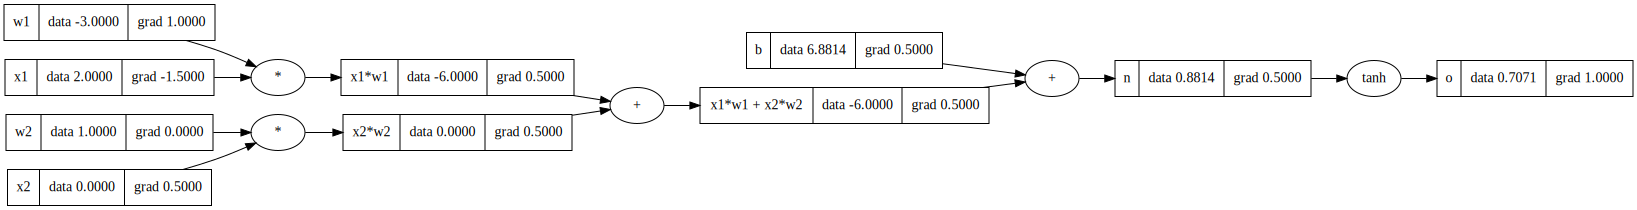

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.881373587019543, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

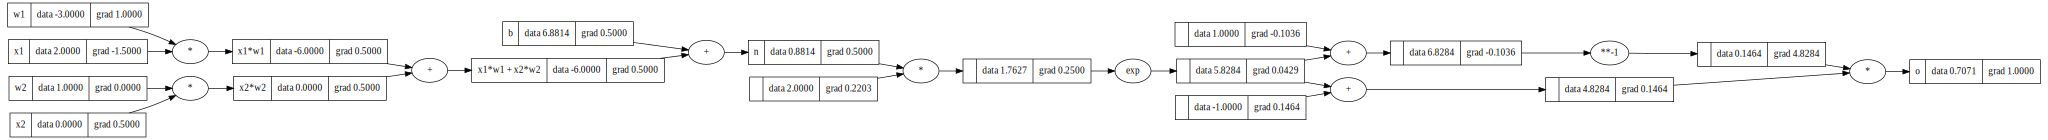

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.881373587019543, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e-1)/(e+1)
# o = n.tanh(); 
o.label = 'o'
o.backward()
draw_dot(o)

In [ ]:
def lol():
    h = 0.001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 =  L.data

    #(a*b+c)*f -> b*f = 6

    a = Value(2.0 , label='a')
    #a.data +=h
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c ; d.label = 'd'
    #d.data += h
    f = Value(-2.0, label='f')
    # f.data +=h
    L = d * f; L.label = 'L'
    L2 = L.data +h
    #derivative of l with respect to a, cos we added h to a
    print((L2 - L1)/h)

lol()

1.000000000000334


# Create NN from scratch

In [ ]:
class Neuron:
  """
  This class will create a neuren, initialize the input, weight, biase
           
  """
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
   
  def parameters(self):
    return self.w + [self.b]

class Layer:
  """
   This class will create a layer
  """
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
    # params = []
    # for neuron in self.neurons:
    #   ps = neuron.parameters()
    #   params.extend(ps)
    # return params

class MLP:
    """
   This class will sum up all
  """
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    #iterate over consecutive pairs
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.6673752193410835)

In [ ]:
len(n.parameters())

41

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets



In [ ]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  #loss: calculate single number that measures the total perfomrmance of the neural net
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 1.0040818462427592
1 0.6975504836514962
2 0.3060217322950291
3 0.04177479319591711
4 0.03662787031569445
5 0.03259885090796627
6 0.029348879613488033
7 0.02666958755449153
8 0.02442277800674944
9 0.02251216099629613
10 0.02086823004959258
11 0.019439426594527423
12 0.018186652535829975
13 0.017079705843447854
14 0.016094883511766155
15 0.01521332378430595
16 0.014419832538667094
17 0.013702035646922215
18 0.01304975599988584
19 0.012454548529873127


In [ ]:
ypred

[Value(data=0.9638030723059683),
 Value(data=-0.962442864628128),
 Value(data=-0.9324275741056551),
 Value(data=0.9281128676549251)]

# Create NN using Tourch

In [ ]:
import torch
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737
